# Chapter-2: Prepare training data

In this chapter, we will go through how to download high-latitude dust (HLD) data from S3 buckets, preprocess them, and split them for training a ML model.
After completing this chapter, you will have familiarized yourself with the process of transfering images into this jupyter notebook instance for further processing. The following objectives are part of this chapter:
- Review and execute code that will download pre-prepared HLD data from an S3 bucket.
- Learn the necessary constants, and the format of each, which are needed to complete the data download.
- Review and execute the code necessary to prepare the environment for data transfer.
- Review and execute code that generates helper methods that facilitate the download and visualization of the data.
- Review and execute code that checks the downloaded data and prepares the splits.


The flow of the process is illustrated in this diagram:

<img src="workflow.png">

### NOTE: Due to time constraints the preprocessing mentioned above has been done and stored in an s3 bucket. While we still be walking through the process, we won't be executing them here. 

## Installation requirements

In [4]:
!pip install -r ../chapter-3/src/requirements.txt

  Using cached Fiona-1.8.20-cp36-cp36m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (15.4 MB)
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached opencv_python_headless-4.5.2.52-cp36-cp36m-manylinux2014_x86_64.whl (38.2 MB)
  Using cached rasterio-1.2.4-cp36-cp36m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (19.3 MB)
     |████████████████████████████████| 394.3 MB 6.4 kB/s  eta 0:00:01     |████████████████████████████    | 345.8 MB 74.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.7 MB/s  eta 0:00:01
     |████████████████████████████████| 10.6 MB 53.9 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 58.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 43.9 MB/s eta 0:00:01     |████▎                           | 501 kB 43.9 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 42.9 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 57.6 MB/s eta 0:00:01
     |████████████████████████████████|

## Import packages

In [7]:
import boto3
import fiona

import math
import numpy as np
import os
import random
import rasterio.features
import cv2
import numpy.ma as ma

import re
import requests
import shutil

from datetime import datetime
from glob import glob
from io import BytesIO
from IPython.display import Image as Display
from PIL import Image
from rasterio.warp import calculate_default_transform
from matplotlib import pyplot as plt

## Setup constant variables

In [8]:
ACCOUNT_NUMBER = <account number>
ROLE_NAME = "notebookAccessRole"
ROLE_ARN = f"arn:aws:iam::{ACCOUNT_NUMBER}:role/{ROLE_NAME}"
SOURCE_BUCKET = "impact-datashare" # identifier for IMPACT's s3 buckets

# NOTE: Use image_url function above to create a valid url, if the shapefile generation was not done in Aqua, TrueColor 
DATA_FOLDER = "../chapter-3/data"
EVENT = "hld-labeled" # Prefix
IMAGE_FOLDER = "images"
SHAPEFILE_FOLDER = "shapefiles"

# worldview image API endpoint
URL = "https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?SERVICE=WMS&REQUEST=GetMap&layers=MODIS_Aqua_CorrectedReflectance_TrueColor&version=1.3.0&crs=EPSG:4326&transparent=false&width={}&height={}&bbox={}&format=image/tiff&time={}"

# parameters required for calculating width/height of a given bounding box
KM_PER_DEG_AT_EQ = 111. 
RESOLUTION = 0.25

BUCKET_NAME = f"{ACCOUNT_NUMBER}-model-bucket". # Location to store data, model and log files
DESTINATION_BUCKET = f"s3://{BUCKET_NAME}"

## Setup environment for Notebook Access

In [9]:
def assumed_role_session():
    """ Assume the "notebookAccessRole" role we created using AWS CDK in chapter-0"""
    client = boto3.client('sts')
    creds = client.assume_role(
        RoleArn=ROLE_ARN,
        RoleSessionName=ROLE_NAME
    )['Credentials']
    return boto3.session.Session(
        aws_access_key_id=creds['AccessKeyId'],
        aws_secret_access_key=creds['SecretAccessKey'],
        aws_session_token=creds['SessionToken'],
        region_name='us-east-1'
    )


### Create and Delete folders

In [10]:
def mkdir(foldername):
    """
    creates folders if 'foldername' doesn't exist
    """
    if os.path.exists(foldername):
        print(f"'{foldername}' folder already exists.")
        return
    os.makedirs(foldername)
    print(f"Created folder: {foldername}")

    
def delete_folder(foldername):
    """deletes folder and its contents """
    if os.path.exists(foldername):
        shutil.rmtree(foldername) 
    else:
        print(f"Folder {foldername} doesn't exist.")
    
    

## Get Image from worldview imagery using their API endpoint

[Worldview](https://earthdata.nasa.gov/worldview): The Worldview tool from NASA's Earth Observing System Data and Information System (EOSDIS) provides the capability to interactively browse over 900 global, full-resolution satellite imagery layers and then download the underlying data. They also provide API endpoints to access the available imagery. The usage is shown below:

In [ ]:
def image_url(query_date, bbox, sensor, product, width, height):
    """create a url to return an image based on the query parameters"""
    BASE_URL = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi'
    param_dict = {
        "BBOX": bbox,
        "CRS": "EPSG:4326",
        "FORMAT": "image/jpeg",
        "HEIGHT": height,
        "LAYERS": "MODIS_%s_CorrectedReflectance_%s" % (sensor, product),
        "REQUEST": "GetMap",
        "SERVICE": "WMS",
        "TIME": query_date,
        "TRANSPARENT": "false",
        "VERSION": "1.3.0",
        "WIDTH": width,
    }

    return "{}?{}".format(BASE_URL, urlencode(param_dict))

## Image querying operations

These set of helper functions are used to calculate the image dimensions of a given extent.

In [ ]:
def calculate_width_height(extent, resolution):
    """
    extent: [lower_latitude, left_longitude, higher_latitude, right_longitude], EG: [51.46162974683544,-22.94768591772153,53.03698575949367,-20.952234968354432]
    resolution: represents the pixel resolution, i.e. km/pixel. Should be a value from this list: [0.03, 0.06, 0.125, 0.25, 0.5, 1, 5, 10]
    """
    lats = extent[::2]
    lons = extent[1::2]
    km_per_deg_at_lat = KM_PER_DEG_AT_EQ * np.cos(np.pi * np.mean(lats) / 180.)
    width = int((lons[1] - lons[0]) * km_per_deg_at_lat / resolution)
    height = int((lats[1] - lats[0]) * KM_PER_DEG_AT_EQ / resolution)
    return (width, height)


def modis_url(time, extent, resolution):
    """
    time: utc time in iso format EG: 2020-02-19T00:00:00Z
    extent: [lower_latitude, left_longitude, higher_latitude, right_longitude], EG: [51.46162974683544,-22.94768591772153,53.03698575949367,-20.952234968354432]
    resolution: represents the pixel resolution, i.e. km/pixel. Should be a value from this list: [0.03, 0.06, 0.125, 0.25, 0.5, 1, 5, 10]
    """
    width, height = calculate_width_height(extent, resolution)
    extent = ','.join(map(lambda x: str(x), extent))
    return (width, height, URL.format(width, height, extent, time))

## Convert shapefiles into rasters 
These set of helper functions are used to convert shapefiles into rasters of 0s and 1s corresponding to the shape:

In [ ]:
def bitmap_from_shp(fiona_shape, transform, img_shape, filename):
    """ extract out the smoke pixels using the shapefile
     from the transform defined
    Args:
        fiona_shape (Collection): fiona shape collection obtained by fiona.open()
        transfrom (rasterio.transfrom.Affine): rasterio transform object
    """
    geoms = []
    y_mtx = np.zeros((img_shape))
    for shape in fiona_shape:
        geoms.append(shape["geometry"])
    bitmap_filename = filename.replace('.shp', '_bitmap.png')
    # raster the geoms onto a bitmap
    geom_map = [(geo, 255) for geo in geoms]
    y_mtx = rasterio.features.rasterize(
        geom_map,
        out_shape=(img_shape[1], img_shape[0]),
        transform=transform
    )
    img = Image.fromarray(y_mtx)
    print(f"Preparing Bitmap: {filename}")
    img.save(f"{DATA_FOLDER}/{IMAGE_FOLDER}/{bitmap_filename}")
    

def explode(coords):
    """
    Explode a GeoJSON geometry's coordinates object and yield coordinate tuples.
    As long as the input is conforming, the type of the geometry doesn't matter.
    """
    for e in coords:
        if isinstance(e, (float, int)):
            yield coords
            break
        else:
            for f in explode(e):
                yield f


def extract_bbox(fiona_shape, offset=0):
    """
    Extract bounding box from shapefile
    """
    x, y = zip(*list(explode(fiona_shape['geometry']['coordinates'])))
    return min(y) - offset, min(x) - offset, max(y) + offset, max(x) + offset

### Download Image from worldview corresponding to the time and location information in the shapefile

In [ ]:
def download_image(date, bounding_box, shapefile_name):
    """
    Download images from worldview (https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/gibs)
    date: date of event
    bounding_box: [lower_latitude, left_longitude, higher_latitude, right_longitude], EG: [51.46162974683544,-22.94768591772153,53.03698575949367,-20.952234968354432]
    """
    resolution = RESOLUTION
    width, height, url = modis_url(date, bounding_box, RESOLUTION)
    print(url)
    response = requests.get(url)
    response.raise_for_status()
    file_name = shapefile_name.replace('shp', 'tiff')
    file_name = f"{DATA_FOLDER}/{IMAGE_FOLDER}/{file_name}"
    print(f"Downloading Image: {file_name}")
    with open(file_name, 'wb') as img_file:
        img_file.write(response.content)
    return width, height, file_name

## Create training, validation and test splits

While training a ML model, there is the danger that your model may overfit to the training set. That is, the model might learn an overly specific function that performs well on your training data, but does not generalize to images it has never seen. This is called overfitting.

The train, validation, and testing splits are built to combat overfitting.


### Train split
The training set the largest corpus of your dataset that you reserve for training your model. After training, any inference on these images will be taken with a grain of salt, since the model has already had a chance to look at and memorize the correct output.

### Validation split
The validation set is a separate section of your dataset that you will use during training to get a sense of how well your model is doing on images that are not being used in training.

### Test split
After all of the training experiments have concluded, you may have a sense of how your model might do on the validation set. But it is important to remember that the validation set metrics may have influenced you during the creation of the model, and in this sense you might, as a designer, overfit the new model to the validation set.

In [16]:
def create_split(split, files):
    """
    Clear and create folder with new files.
    split: choice of "train", "test", and "val"
    files: list of tiff file paths

    """
    print(f'Preparing {split} split with {len(files)} examples.')
    folder_name = f"{DATA_FOLDER}/{split}"
    if os.path.exists(folder_name):
        delete_folder(folder_name)
    mkdir(folder_name)
    for filename in files:
        internal_filename = filename.split('/')[-1]
        bitmap_filename = filename.replace('.tiff', '_bitmap.png')
        shutil.copyfile(filename, f"{folder_name}/{internal_filename}")
        shutil.copyfile(bitmap_filename, f"{folder_name}/{bitmap_filename.split('/')[-1]}")
         
# Prepare train, val, and test splits
def prepare_splits(source_folder, splits={'train': 0.6, 'val': 0.2, 'test': 0.2}):
    """ Creates training, validation and test splits from `source folder`
    """
    files = glob(f"{source_folder}/*.tiff")
    print(f"Total examples found: {len(files)}")
    random.shuffle(files)
    length = len(files)
    train_limit = math.ceil(length * splits['train'])
    val_limit = train_limit + math.ceil(length * splits['train'])
    create_split('train', files[0:train_limit])
    create_split('val', files[train_limit:val_limit])
    create_split('test', files[train_limit:val_limit])
    

## Download shapefiles from S3 bucket and images from WorldView
- This function downloads the shapefiles that we previously labeled using imagelabeler.
- The date-time and bounds of the shapefiles are found and the corresponding GIBS imagery is downloaded
- The shapefiles are converted into bitmaps, which will serve as training labels.
- The Images are finally stored in `DATA_FOLDER`


In [ ]:
def prepare_datasets(boto_session):
    """
    Download and prepare images from available shapefiles
    boto_session: Boto session currently in use.
    """
    s3_connection = boto_session.resource('s3')
    bucket = s3_connection.Bucket(SOURCE_BUCKET)
    objects = list(bucket.objects.filter(Prefix=f"hld/"))
    foldername = f"{DATA_FOLDER}/{SHAPEFILE_FOLDER}"
    mkdir(foldername)
    for iter_object in objects:
        print(iter_object.key)
        splits = iter_object.key.split('/')
        local_foldername = f"{foldername}/{splits[1]}"
        mkdir(local_foldername)
        filename = f"{local_foldername}/{splits[-1]}"
        if not(os.path.exists(filename)):
            bucket.download_file(iter_object.key, filename)
        else: 
            print(f"File already exists. {filename}")
    mkdir(f"{DATA_FOLDER}/{IMAGE_FOLDER}")
    for shapefilename in glob(f"{foldername}/*/*.shp"):
        date = shapefilename.split('_')[1]
        filename = shapefilename.split('/')[-1]
        with fiona.open(shapefilename, "r") as shapefile:
            bounds = shapefile.bounds
            bounds = [bounds[1], bounds[0], bounds[3], bounds[2]]
            width, height, image_filename = download_image(date, bounds, filename)
            try:
                with rasterio.open(image_filename) as src:
                    bitmap_from_shp(shapefile, src.transform, (width, height), filename)
            except:
                print(f"Unable to download file: {image_filename}")
                os.remove(image_filename)


## Download processed images that are stored in the S3 bucket, in case the above processing step fails

In [12]:
def download_dataset(boto_session):
    """
    Download and store data in folders.
    boto_session: Boto session currently in use.
    """
    s3_connection = session.resource('s3')
    bucket = s3_connection.Bucket(SOURCE_BUCKET)
    objects = list(bucket.objects.filter(Prefix=f"{EVENT}/"))
    foldername = f"{DATA_FOLDER}/{IMAGE_FOLDER}"
    mkdir(foldername)
    for iter_object in objects:
        print(iter_object.key)
        splits = iter_object.key.split('/')
        if splits[-1]:
            filename = f"{foldername}/{splits[-1]}"
            bucket.download_file(iter_object.key, filename)


## Putting it all together: from creating a session with permissions to preparing the dataset

In [18]:
session = assumed_role_session()  # Create an AWS session with appropriate permissions
# prepare_datasets(session) # Preprocess shapefiles and images to ML-ready format 
#download_dataset(session) # Download preprocessed dataset
prepare_splits(f"{DATA_FOLDER}/{IMAGE_FOLDER}")  # Create splits for training

Total examples found: 44
Preparing train split with 27 examples.
Created folder: ../chapter-3/data/train
Preparing val split with 17 examples.
Created folder: ../chapter-3/data/val
Preparing test split with 17 examples.
Created folder: ../chapter-3/data/test


## Visualize downloads

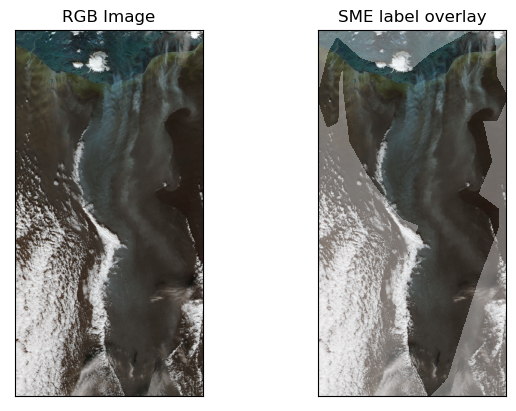

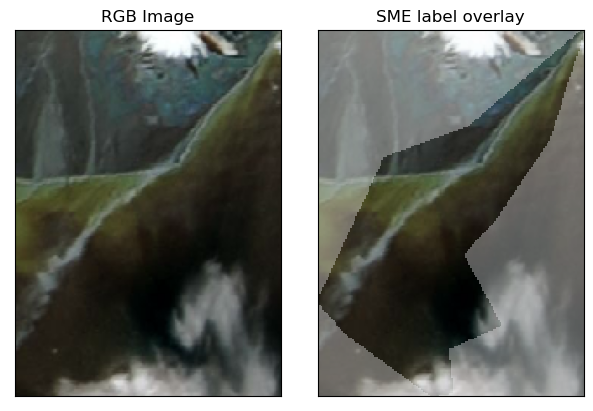

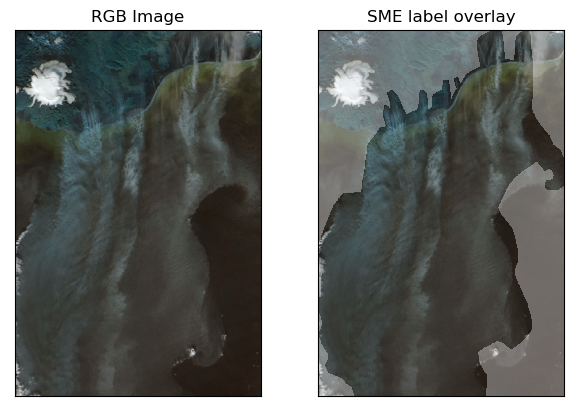

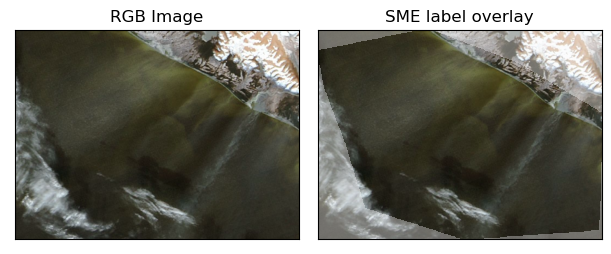

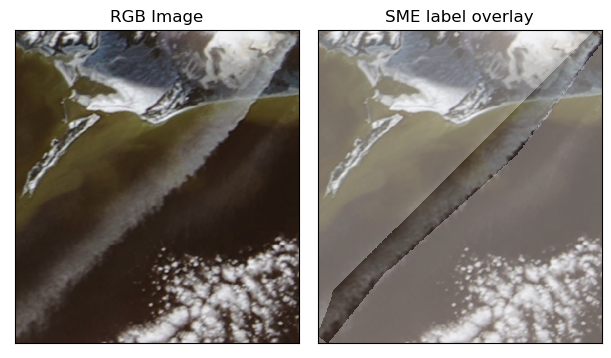

In [19]:
def get_test_data(num_samples=5):
    """ Samples 'num_samples' # of test datasets from the test data split,
    returns the images and the labels
    """
    test_array = []
    bmp_array = []
    all_images = glob(f'{DATA_FOLDER}/test/*.tif*')
    random.shuffle(all_images)
    test_images_sampled = all_images[:num_samples]
    for test_image in test_images_sampled:
        image = cv2.imread(test_image)
        bmp_image = cv2.imread(test_image.replace('.tiff','_bitmap.png'))
        test_array.append(image)
        bmp_array.append(bmp_image)
    return test_array, bmp_array

modis_batch, bmp_batch = get_test_data()

for j in range(len(modis_batch)):
    bmp_data = bmp_batch[j]
    f, ax = plt.subplots(1, 2, constrained_layout=True, dpi=100)
    ax[0].imshow(modis_batch[j].astype('uint8'))
    ax[0].set_title('RGB Image')
    ax[0].xaxis.set_ticks([])
    ax[0].yaxis.set_ticks([])
    ax[1].imshow(modis_batch[j].astype('uint8'))
    ax[1].xaxis.set_ticks([])
    ax[1].yaxis.set_ticks([])
    ax[1].set_title('SME label overlay')
    ax[1].imshow(ma.masked_where(bmp_data != 0, bmp_data)[:,:,0],alpha=0.35,cmap='Purples')

## This concludes Chapter-2. Come back to this notebook after Chapter-3 and execute following cells

# Note the trained model name in the DESTINATION_BUCKET dashboard

This will be used in the next chapter to deploy and infer from the model.


## Attach a Tensorboard session

Tensorboard in an interactive model training visualization tool. This lets us monitor the training/validation losses over time and gives an idea of how good the model is training. (Since we are passing the logs to s3, we can interact with the logs directly from our local setup.)
Here's how you'd connect your tensorboard to your s3 bucket.
1. install tensorboard version 2.4.1 using `pip install tensorboard==2.4.1`
2. run `AWS_REGION=<the region you selected> tensorboard --logdir s3://<your account number>-model-bucket/tensorboard_logs/`
3. Navigate to localhost:6006 to view the model metrics, model graph timeline and more.


You could also try running it via this very notebook using the following cell. (Will be useful in chapter-3)

In [ ]:
!pip uninstall tensorboard -y
!pip install tensorboard\<2.4
LOG_FOLDER = "tensorboard_logs"
TENSORFLOW_LOGS_PATH = f"s3://{BUCKET_NAME}/{LOG_FOLDER}"
# The corresponding tensorboard can be accessed using `https://<your-notebook-instance-name>/proxy/6006/` the https and the trailing spaces are very important.
!AWS_REGION=us-east-1 tensorboard --logdir {TENSORFLOW_LOGS_PATH}

Found existing installation: tensorboard 2.4.1
Uninstalling tensorboard-2.4.1:
  Successfully uninstalled tensorboard-2.4.1
     |████████████████████████████████| 6.8 MB 10.5 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires tensorboard~=2.4, but you have tensorboard 2.3.0 which is incompatible.
tensorflow-serving-api 2.1.0 requires tensorflow~=2.1.0, but you have tensorflow 2.4.1 which is incompatible.
tensorflow-cpu 2.1.3 requires gast==0.2.2, but you have gast 0.3.3 which is incompatible.
tensorflow-cpu 2.1.3 requires keras-preprocessing==1.1.0, but you have keras-preprocessing 1.1.2 which is incompatible.
tensorflow-cpu 2.1.3 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.5 which is incompatible.
tensorflow-cpu 2.1.3 requires tensorboard<2.2.0,>=2.1.0, but you have tensorboard 2.3.0 which is incompatible.
t